In [27]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import os
import math

In [28]:
# Collecting a subset of 20,000 images to train, calibrate and test
# Shuffling the dataset to remove patterns/groups of related images
import random
random.seed(10) # comment out later
img_index = [i for i in range(20000)]
random.shuffle(img_index)


In [29]:
# Storing attributes Smiling, Male, Young.. for each image
import pandas as pd
df = pd.read_csv('list_attr_celeba.txt', skiprows=1, header=0, sep='\s+')

img_df = df[["Smiling", "Male", "Young", "Blond_Hair"]].head(20000)

In [30]:
# Feature extraction
def extract_features():
    """
    Extracts features from images using a pre-trained Vision Transformer (ViT)
    and saves them to a file.
    """
    EMBEDDINGS_FILE = 'embeddings.npy'
    IMAGE_DIR = 'celeba_selection'
    NUM_IMAGES_TO_PROCESS = 20000 #later change to SAMPLE_SIZE
    random.seed(10) # comment out later, for reproducibility

    if os.path.exists(EMBEDDINGS_FILE):
        print(f"Embeddings file ’{EMBEDDINGS_FILE}’ already exists. Skipping feature extraction.")
        return
    print("Starting feature extraction with Vision Transformer...")

    # 1. Load pre-trained Vision Transformer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1).to(device)
    vit.eval() # Set model to evaluation mode

    # 2. Define preprocessing steps consistent with ImageNet training
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # 3. Get the list of images to process

    image_list = sorted(os.listdir(IMAGE_DIR))[:NUM_IMAGES_TO_PROCESS]
    all_features = []

    # 4. Extract embeddings for each image
    with torch.no_grad():
        for fname in tqdm(image_list, desc="Extracting ViT Embeddings"):
            img = Image.open(os.path.join(IMAGE_DIR, fname)).convert("RGB")
            x = preprocess(img).unsqueeze(0).to(device)
            # Manually replicate the forward pass to get the features before the
            # classification head, as the internal API (like .process_input)
            # can change.
            # 1. Process input using the private _process_input method
            x_processed = vit._process_input(x)
            n = x_processed.shape[0]
            # 2. Add the class token
            batch_class_token = vit.class_token.expand(n, -1, -1)
            x_with_token = torch.cat([batch_class_token, x_processed], dim=1)
            # 3. Pass through the encoder
            encoded_features = vit.encoder(x_with_token)
            # 4. Get the class token’s output (this is the feature vector)
            features = encoded_features[:, 0]
            all_features.append(features.cpu().numpy().flatten())
    all_features_np = np.array(all_features)
    print(f"Feature matrix shape: {all_features_np.shape}")
    
    # 5. Save embeddings for later use
    np.save(EMBEDDINGS_FILE, all_features_np)
    print(f"Embeddings saved to ’{EMBEDDINGS_FILE}’.")

extract_features()



Embeddings file ’embeddings.npy’ already exists. Skipping feature extraction.


In [31]:
# Partitioning the data into training/calibration/test data
embeddings = np.load("embeddings.npy")

SAMPLE_SIZE = 20000

TRAIN_RATIO = 0.7
CALIBRATION_RATIO = 0.15
TEST_RATIO = 0.15

train_index = int(TRAIN_RATIO * SAMPLE_SIZE)
calibration_index = train_index + int(CALIBRATION_RATIO * SAMPLE_SIZE)

# note - shuffle with labels later
train_embed, calibration_embed, test_embed = np.split(embeddings, [train_index, calibration_index]) 
train_labels = img_df.iloc[:train_index]
calibration_labels = img_df.iloc[train_index:calibration_index]
test_labels = img_df.iloc[calibration_index:]

In [32]:
# Modelling the Naive Bayes Model
train_embed_df = pd.DataFrame(train_embed)

def calc_mean_sd(label):
    temp_df = train_embed_df.copy()
    temp_df['label'] = train_labels[label].values

    dict_mean_sd = {}

    for c in [-1, 1]:
        feature_class = temp_df[temp_df['label'] == c].iloc[:, :-1]
        means, sds = feature_class.mean().values, feature_class.std().values
        dict_mean_sd[c] = [means, sds]

    return dict_mean_sd

stats = calc_mean_sd("Smiling")

# We model each feature (conditioned on label) under a gaussian distribution
def pd_gaussian(x, mean, sd):  
    var = math.pow(sd,2)
    exponent = -((math.pow(x - mean, 2)) / (2 * var))
    return (1 / math.sqrt(2 * math.pi * var)) * math.exp(exponent)


def naive_bayes_class(feature, label):
    # calc bayes prob for both classes of label
    # compare both
    pos = naive_bayes(feature, label, 1)
    neg = naive_bayes(feature, label, -1)
    classification = 1 if pos > neg else 0
    return classification


def naive_bayes(feature, label, label_class):
    return likelihood(feature, label, label_class) + math.log(prior(label, label_class))


# Returns probability a sample is given a particular label/class 
def prior(label, label_class):
    label_count = train_labels[label].value_counts()[label_class]
    return (label_count/len(train_labels))


# Returns conditional probability a feature is present given a label and class
def likelihood(feature, label, label_class):  
    likelihood_total = 0
    means = stats[label_class][0]
    sds = stats[label_class][1]

    for i in range(len(feature)):
        likelihood_total += math.log(pd_gaussian(feature[i], means[i], sds[i]))

    return likelihood_total

In [33]:
# Calculating accuracy for smiling

""" 
    label - string
    ground_truth - pandas series
    set - numpy array
"""
def accuracy(label, ground_truth, set):
    ground_truth = ground_truth["Smiling"].replace(-1, 0)
    correct_pred = 0
    for i in range(len(set)):
        pred = naive_bayes_class(set[i], label)
        if pred == ground_truth.iloc[i]:
            correct_pred += 1

    accuracy = correct_pred / len(set)
    return accuracy

# Test accuracy
print(accuracy("Smiling", test_labels, test_embed))

0.6903333333333334


[np.int64(1422), 0, 0, 0, np.int64(1)]


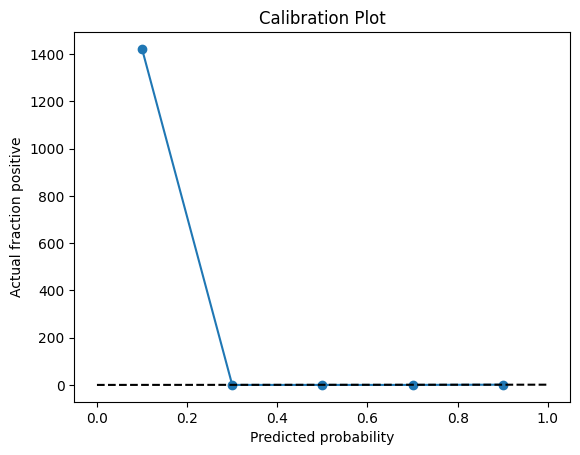

In [ ]:
# Part B - Population Calibration

# Calculate probabilities of calibration set
from scipy.special import softmax
import matplotlib.pyplot as plt

predictions = []

for feature in calibration_embed:
    predictions.append(naive_bayes(feature, "Smiling", 1))
    

# Use softmax function to convert log-probabilities into probabilities
# Ask if we can use a built in softmax function
# def softmax(log_probabilities):
#     exponents = np.exp(log_probabilities - np.max(log_probabilities))
#     return exponents/np.sum(exponents)

# set of p(x)
probabilities = softmax(np.array(predictions))   

bins = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
bin_indices = np.digitize(probabilities, bins)

counts = np.bincount(bin_indices - 1, minlength=len(bins)-1)

smiling = calibration_labels['Smiling']
actual_probabilites = []

# actual probabilities
for i in range(1, np.max(bin_indices)+1):
    samples = np.where(bin_indices == i)[0]
    label_subset = smiling.iloc[samples]
    correct_count = label_subset.value_counts()
    num_ones = correct_count.get(1, 0)
    actual_probabilites.append(num_ones)


